# Image Preprocessing & Augmentation

**Segmentation**  
We experimented with background subtraction / color-based segmentation to isolate the hand from the background. However, the images in our dataset already have clean backgrounds with minimal noise. Therefore, the segmented images looked very similar to the originals, and segmentation did not add significant benefit for training.

---

**Normalization**  
We applied normalization to scale pixel values from the range [0, 255] down to [0, 1]. This ensures more stable training and faster convergence.

---

**Data Augmentation**  
We applied data augmentation To increase dataset variability and reduce overfitting by creating modified versions of training images so the model can generalize better to unseen data.  

We used the following transformations:  
- **Random Flip (horizontal):** Helps the model learn that left/right orientations of the hand are equally valid.  
- **Random Rotation (0.1):** Introduces slight rotations to simulate natural variation in how hands appear.  
- **Random Zoom (0.1):** Covers different hand sizes or distances from the camera.  
- **Random Translation (0.1, 0.1):** Allows the model to handle shifts in hand position.  
- **Random Contrast (0.1):** Teaches the model to be able to handle different lighting conditions.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
import random
import mediapipe as mp

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [4]:
def compare_segmented_images(original_split_path, segmented_split_path, num_samples=5):
    """
    Display random before/after segmentation image pairs side-by-side.

    Parameters:
    - original_split_path: path to the split folder of the original dataset (e.g., train/val/test)
    - segmented_split_path: path to the split folder of the segmented dataset
    - num_samples: number of image pairs to display
    """

    # Validate directories
    if not os.path.exists(original_split_path) or not os.path.exists(segmented_split_path):
        raise ValueError("Invalid paths. Check that both folders exist.")

    # Get all class folders
    class_names = [cls for cls in os.listdir(original_split_path)
                   if os.path.isdir(os.path.join(original_split_path, cls))]

    if not class_names:
        raise ValueError(f"No class folders found in {original_split_path}")

    # Choose random class
    chosen_class = random.choice(class_names)
    print(f"Selected class: {chosen_class}")

    # List all images from that class
    orig_class_path = os.path.join(original_split_path, chosen_class)
    seg_class_path = os.path.join(segmented_split_path, chosen_class)

    orig_images = os.listdir(orig_class_path)
    seg_images = os.listdir(seg_class_path)

    # Find common filenames
    common_files = list(set(orig_images) & set(seg_images))
    if not common_files:
        raise ValueError(f"No common image filenames found in {chosen_class}.")

    # Randomly select N samples
    selected_files = random.sample(common_files, min(num_samples, len(common_files)))


 # Create a figure with 2 rows (Originals on top, Segmented below)
    fig, axes = plt.subplots(2, num_samples, figsize=(4 * num_samples, 8))
    fig.suptitle(f"Original vs Segmented Images ({chosen_class})", fontsize=14)

    for i, fname in enumerate(selected_files):
        orig_path = os.path.join(orig_class_path, fname)
        seg_path = os.path.join(seg_class_path, fname)

        orig_img = cv2.imread(orig_path)
        seg_img = cv2.imread(seg_path)

        if orig_img is None or seg_img is None:
            print(f"Skipping unreadable image: {fname}")
            continue

        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)

        # Top row: Original
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(f"Original ({fname})", fontsize=10)
        axes[0, i].axis("off")

        # Bottom row: Segmented
        axes[1, i].imshow(seg_img)
        axes[1, i].set_title("Segmented")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

In [5]:
train_dir = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/train"
val_dir   = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/val"
test_dir  = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/test"

train_dir_seg = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset_segmented/train"
val_dir_seg   = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset_segmented/val"
test_dir_seg  = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset_segmented/test"

Selected class: 05_thumb


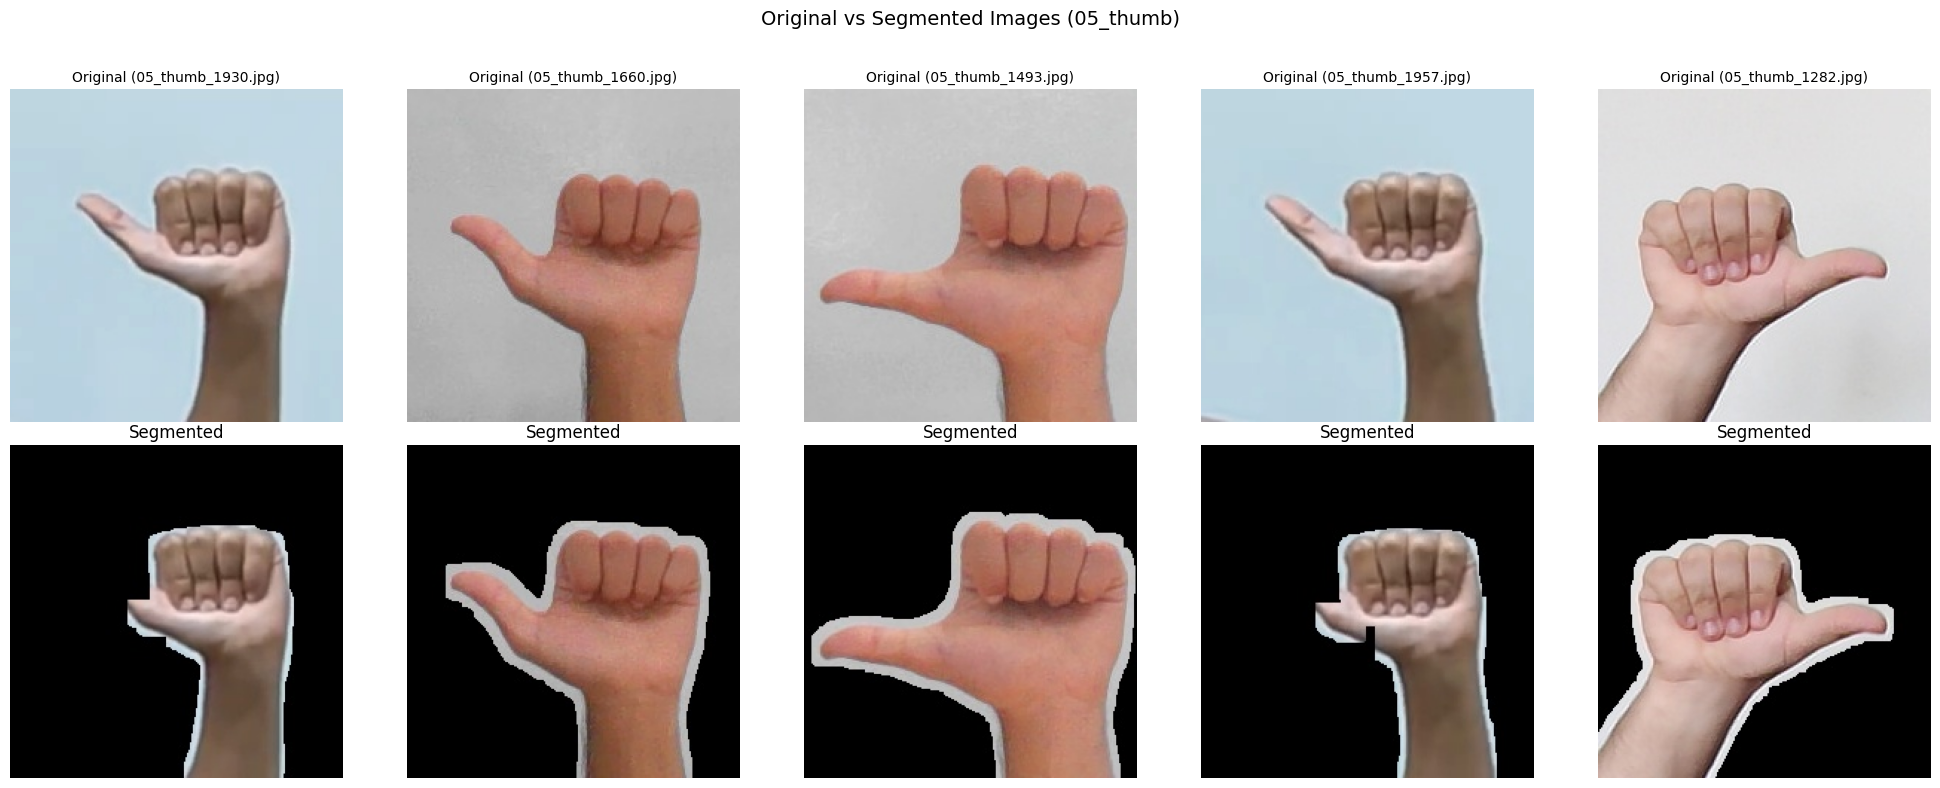

In [7]:
compare_segmented_images(
    original_split_path = train_dir,
    segmented_split_path=train_dir_seg,
    num_samples=5
)

In [6]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=256,
    seed=111,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=256,
    seed=111,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=256,
    seed=111,
    shuffle=False
)

Found 18739 files belonging to 10 classes.
Found 4012 files belonging to 10 classes.
Found 4026 files belonging to 10 classes.


In [8]:
# Define the Normalization Layer
normalization_layer = layers.Rescaling(1./255)

In [9]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

In [10]:
# Apply preprocessing to The Images
train_data = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
val_data   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_data  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Draw Landmarks on the hands

In [ ]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

In [ ]:
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

base_path = "Dataset"
split_data = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test)
}

for split, (X, y) in split_data.items():
    split_path = os.path.join(base_path, split)
    if not os.path.isdir(split_path):
        continue
    print(f"Processing {split} data...")
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    landmark_points = []
                    for lm in hand_landmarks.landmark:
                        landmark_points.extend([lm.x, lm.y, lm.z])
                    # Normalize by wrist position
                    pts = np.array(landmark_points)
                    wrist_x, wrist_y = pts[0], pts[1]
                    pts[0::3] -= wrist_x
                    pts[1::3] -= wrist_y
                    X.append(pts)
                    y.append(label)

Processing train data...


Processing val data...
Processing test data...
Processing test data...


In [ ]:
# Convert to numpy arrays and save data
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save the landmarks and labels
print("Saving landmarks and labels...")
np.savez('data/landmarks_train.npz', X=X_train, y=y_train)
np.savez('data/landmarks_val.npz', X=X_val, y=y_val)
np.savez('data/landmarks_test.npz', X=X_test, y=y_test)

print("Train:", X_train.shape, len(y_train))
print("Val:", X_val.shape, len(y_val))
print("Test:", X_test.shape, len(y_test))

print("\nData saved successfully! Next time you can skip the extraction by running the next cell.")

Saving landmarks and labels...
Train: (16401, 63) 16401
Val: (3526, 63) 3526
Test: (3514, 63) 3514

Data saved successfully! Next time you can skip the extraction by running the next cell.


# Load Pre-extracted Landmarks (Optional)

If you have already extracted and saved the landmarks, you can load them directly by running this cell instead of extracting them again.

In [ ]:
# Load the saved landmarks and labels
print("Loading saved landmarks...")
train_data = np.load('data/landmarks_train.npz')
val_data = np.load('data/landmarks_val.npz')
test_data = np.load('data/landmarks_test.npz')

X_train, y_train = train_data['X'], train_data['y']
X_val, y_val = val_data['X'], val_data['y']
X_test, y_test = test_data['X'], test_data['y']

print("Train:", X_train.shape, len(y_train))
print("Val:", X_val.shape, len(y_val))
print("Test:", X_test.shape, len(y_test))

Loading saved landmarks...
Train: (16401, 63) 16401
Val: (3526, 63) 3526
Test: (3514, 63) 3514
Train: (16401, 63) 16401
Val: (3526, 63) 3526
Test: (3514, 63) 3514


In [ ]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Save the landmarks and labels
print("Saving landmarks and labels...")
np.savez('data/landmarks_train.npz', X=X_train, y=y_train)
np.savez('data/landmarks_val.npz', X=X_val, y=y_val)
np.savez('data/landmarks_test.npz', X=X_test, y=y_test)

print("Train:", X_train.shape, len(y_train))
print("Val:", X_val.shape, len(y_val))
print("Test:", X_test.shape, len(y_test))

Saving landmarks and labels...
Train: (16401, 63) 16401
Val: (3526, 63) 3526
Test: (3514, 63) 3514


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Fit on all labels to ensure same encoding across sets
all_labels = np.concatenate([y_train, y_val, y_test])
le.fit(all_labels)

y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [ ]:
model = Sequential([
    Dense(256, input_shape=(63,)),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])
model.summary()

c:\Users\gidge\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,794 (495.29 KB)

 Trainable params: 125,386 (489.79 KB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\nTest accuracy: {test_acc:.4f}")

Epoch 1/50
511/513 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8280 - loss: 0.5640

513/513 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8286 - loss: 0.5622 - val_accuracy: 0.9926 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
511/513 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9796 - loss: 0.0811

513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9796 - loss: 0.0810 - val_accuracy: 0.9960 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9829 - loss: 0.0560 - val_accuracy: 0.9949 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 4/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9829 - loss: 0.0560 - val_accuracy: 0.9949 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 4/50
509/513 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9851 - loss: 0.0577

513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9851 - loss: 0.0576 - val_accuracy: 0.9983 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 5/50
Epoch 5/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9861 - loss: 0.0474 - val_accuracy: 0.9895 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 6/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9861 - loss: 0.0474 - val_accuracy: 0.9895 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 6/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9883 - loss: 0.0453 - val_accuracy: 0.9844 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 7/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9883 - loss: 0.0453 - val_accuracy: 0.9844 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 7/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9897 - loss: 0.0370 - val_accuracy: 0.9972 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 8/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9897 - loss: 0.

513/513 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9941 - loss: 0.0204 - val_accuracy: 0.9986 - val_loss: 0.0097 - learning_rate: 5.0000e-04
Epoch 11/50
Epoch 11/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9950 - loss: 0.0182 - val_accuracy: 0.9977 - val_loss: 0.0122 - learning_rate: 5.0000e-04
Epoch 12/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9950 - loss: 0.0182 - val_accuracy: 0.9977 - val_loss: 0.0122 - learning_rate: 5.0000e-04
Epoch 12/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9955 - loss: 0.0161 - val_accuracy: 0.9966 - val_loss: 0.0142 - learning_rate: 5.0000e-04
Epoch 13/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9955 - loss: 0.0161 - val_accuracy: 0.9966 - val_loss: 0.0142 - learning_rate: 5.0000e-04
Epoch 13/50
511/513 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9944 - loss: 0.0198

513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9944 - loss: 0.0198 - val_accuracy: 0.9974 - val_loss: 0.0077 - learning_rate: 5.0000e-04
Epoch 14/50
Epoch 14/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9963 - loss: 0.0154 - val_accuracy: 0.9969 - val_loss: 0.0115 - learning_rate: 5.0000e-04
Epoch 15/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9963 - loss: 0.0154 - val_accuracy: 0.9969 - val_loss: 0.0115 - learning_rate: 5.0000e-04
Epoch 15/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9948 - loss: 0.0164 - val_accuracy: 0.9983 - val_loss: 0.0099 - learning_rate: 5.0000e-04
Epoch 16/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9948 - loss: 0.0164 - val_accuracy: 0.9983 - val_loss: 0.0099 - learning_rate: 5.0000e-04
Epoch 16/50
512/513 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9955 - loss: 0.0177

513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9955 - loss: 0.0177 - val_accuracy: 0.9989 - val_loss: 0.0072 - learning_rate: 5.0000e-04
Epoch 17/50
Epoch 17/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9951 - loss: 0.0167 - val_accuracy: 0.9989 - val_loss: 0.0095 - learning_rate: 5.0000e-04
Epoch 18/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9951 - loss: 0.0167 - val_accuracy: 0.9989 - val_loss: 0.0095 - learning_rate: 5.0000e-04
Epoch 18/50
511/513 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9964 - loss: 0.0164

513/513 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9964 - loss: 0.0164 - val_accuracy: 0.9989 - val_loss: 0.0067 - learning_rate: 5.0000e-04
Epoch 19/50
Epoch 19/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9960 - loss: 0.0137 - val_accuracy: 0.9955 - val_loss: 0.0171 - learning_rate: 5.0000e-04
Epoch 20/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9960 - loss: 0.0137 - val_accuracy: 0.9955 - val_loss: 0.0171 - learning_rate: 5.0000e-04
Epoch 20/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9961 - loss: 0.0163 - val_accuracy: 0.9989 - val_loss: 0.0082 - learning_rate: 5.0000e-04
Epoch 21/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9961 - loss: 0.0163 - val_accuracy: 0.9989 - val_loss: 0.0082 - learning_rate: 5.0000e-04
Epoch 21/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9954 - loss: 0.0144 - val_accuracy: 0.9986 - val_loss: 0.0095 - learning_rate: 5.0000e-04
Epoch 22/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 18s 1

513/513 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9967 - loss: 0.0114 - val_accuracy: 0.9989 - val_loss: 0.0062 - learning_rate: 2.5000e-04
Epoch 25/50
Epoch 25/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9982 - loss: 0.0073 - val_accuracy: 0.9989 - val_loss: 0.0072 - learning_rate: 2.5000e-04
Epoch 26/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9982 - loss: 0.0073 - val_accuracy: 0.9989 - val_loss: 0.0072 - learning_rate: 2.5000e-04
Epoch 26/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9973 - loss: 0.0112 - val_accuracy: 0.9986 - val_loss: 0.0089 - learning_rate: 2.5000e-04
Epoch 27/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9973 - loss: 0.0112 - val_accuracy: 0.9986 - val_loss: 0.0089 - learning_rate: 2.5000e-04
Epoch 27/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9980 - loss: 0.0077 - val_accuracy: 0.9989 - val_loss: 0.0077 - learning_rate: 2.5000e-04
Epoch 28/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15m

513/513 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9972 - loss: 0.0091 - val_accuracy: 0.9989 - val_loss: 0.0056 - learning_rate: 1.2500e-04
Epoch 31/50
Epoch 31/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9981 - loss: 0.0068 - val_accuracy: 0.9989 - val_loss: 0.0061 - learning_rate: 1.2500e-04
Epoch 32/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9981 - loss: 0.0068 - val_accuracy: 0.9989 - val_loss: 0.0061 - learning_rate: 1.2500e-04
Epoch 32/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accuracy: 0.9989 - val_loss: 0.0061 - learning_rate: 1.2500e-04
Epoch 33/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accuracy: 0.9989 - val_loss: 0.0061 - learning_rate: 1.2500e-04
Epoch 33/50
512/513 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9988 - loss: 0.0055

513/513 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9988 - loss: 0.0055 - val_accuracy: 0.9989 - val_loss: 0.0047 - learning_rate: 1.2500e-04
Epoch 34/50
Epoch 34/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9990 - loss: 0.0051 - val_accuracy: 0.9989 - val_loss: 0.0062 - learning_rate: 1.2500e-04
Epoch 35/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9990 - loss: 0.0051 - val_accuracy: 0.9989 - val_loss: 0.0062 - learning_rate: 1.2500e-04
Epoch 35/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9988 - loss: 0.0052 - val_accuracy: 0.9989 - val_loss: 0.0052 - learning_rate: 1.2500e-04
Epoch 36/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9988 - loss: 0.0052 - val_accuracy: 0.9989 - val_loss: 0.0052 - learning_rate: 1.2500e-04
Epoch 36/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9987 - loss: 0.0055 - val_accuracy: 0.9989 - val_loss: 0.0056 - learning_rate: 1.2500e-04
Epoch 37/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/

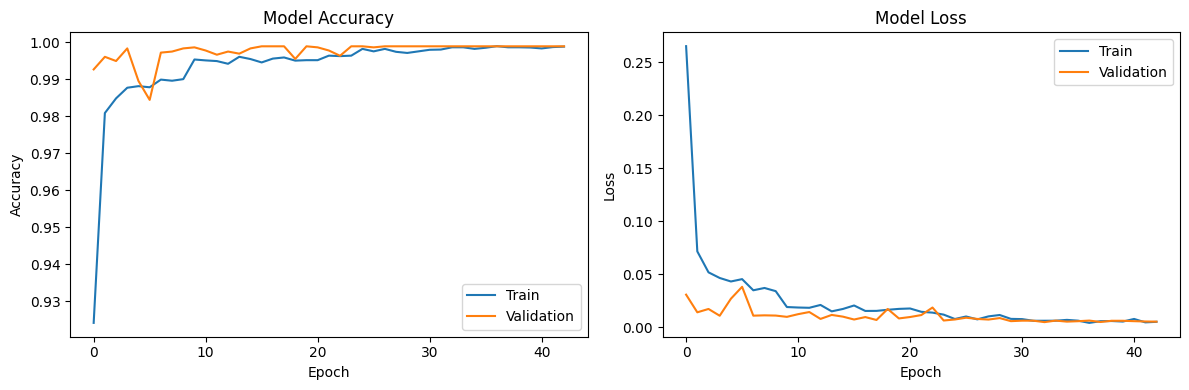

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes,
                          target_names=le.classes_))


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       370
         02_l       1.00      0.99      1.00       352
      03_fist       1.00      1.00      1.00       353
04_fist_moved       1.00      1.00      1.00       329
     05_thumb       1.00      1.00      1.00       370
     06_index       1.00      1.00      1.00       357
        07_ok       1.00      1.00      1.00       429
08_palm_moved       0.99      1.00      1.00       222
         09_c       1.00      1.00      1.00       333
      10_down       1.00      1.00      1.00       399

     accuracy                           1.00      3514
    macro avg       1.00      1.00      1.00      3514
 weighted avg       1.00      1.00      1.00      3514


Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00     

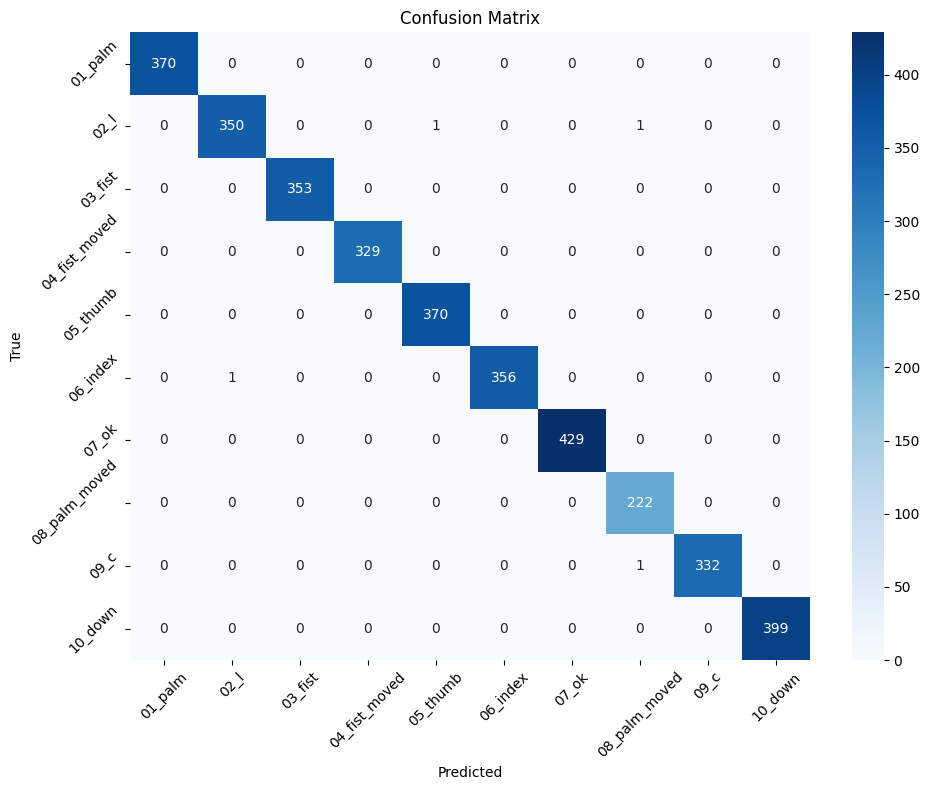

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pickle
with open('hand_gesture_model.pkl', 'wb') as f:
    pickle.dump((model, le), f)
